In [1]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.interpolate import interp1d, RegularGridInterpolator
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

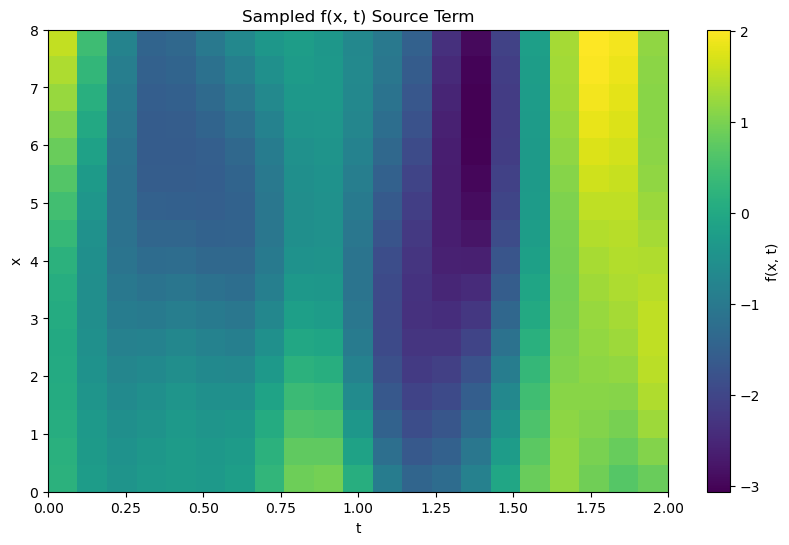

In [103]:


L = 8.0  # Length
T = 2.0  # Time period
c = 1.0  # Wave speed
dx = 0.5  # Spatial step size
dt = 0.2  # Temporal step size
xmin = -5.0
xmax = 5.0
Nx = int((xmax-xmin)/dx) + 1  # Number of spatial points
Nt = int(3/dt) + 2  # Number of temporal points
x = np.linspace(xmin, xmax, Nx)  # Space grid
t = np.linspace(0, T, Nt)  # Time grid

if c * dt / dx > 1:
    raise ValueError("Stability condition violated: c*dt/dx must be <= 1")

# Define Gaussian Process Regressor for f(x, t)
X_xt = np.array([[ti, xi] for ti in t for xi in x])
kernel_xt = 1.0 * RBF(length_scale=1.0)
gpr_xt = GaussianProcessRegressor(kernel=kernel_xt, random_state=42)
f_xt_samples = gpr_xt.sample_y(X_xt, n_samples=10).reshape(Nt, Nx, 10)


# Plot a single f(x, t) source term
plt.figure(figsize=(10,6))
plt.imshow(f_xt_samples[:, :, 0], extent=[0, T, 0, L], origin='lower', aspect='auto')
plt.colorbar(label='f(x, t)')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Sampled f(x, t) Source Term')
plt.show()

In [43]:

#Solution to the second-order wave equation for given source terms
def sinc(x):
    newx = np.array([xi if np.abs(xi) > 1e-8 else 1e-8 for xi in x])
    return np.sin(3*newx)/(3*newx)

def solve_wave(f_xt):
    # u0 = np.sin(np.pi*x/L)
    u0 = np.sinc(x)
    u = np.zeros((Nt, Nx))
    u[0, :] = u0
    u[1,:] = u[0,:]

    sigma = c * dt / dx
    if sigma > 1:
      raise ValueError("The scheme is unstable: sigma should be <= 1")
    #using finite difference method to solve the wave equation
    for n in range(1,Nt-1):
        for i in range(1,Nx-1):
            u[n+1, i] = (2 * u[n, i] - u[n-1, i] +
                     sigma**2 * (u[n, i+1] - 2 * u[n, i] + u[n, i-1])
                )+dt**2*f_xt[n,i]

        #Apply the boundary conditions (Dirichlet）
        u[n+1, 0] = 0
        u[n+1, -1] = 0

    return u

# Plot the results
# for i in range(10):
#   u_f_xt = solve_wave(f_xt_samples[:, :, i])  # Solution for f(x, t)
#   plt.imshow(u_f_xt, extent=[0,L,0,T], aspect='auto', cmap='viridis', origin='lower')
#   plt.xlabel('x')
#   plt.ylabel('u')
#   plt.title('Wave Equation Solutions for Different Source Terms')
#   plt.legend()
#   plt.show()

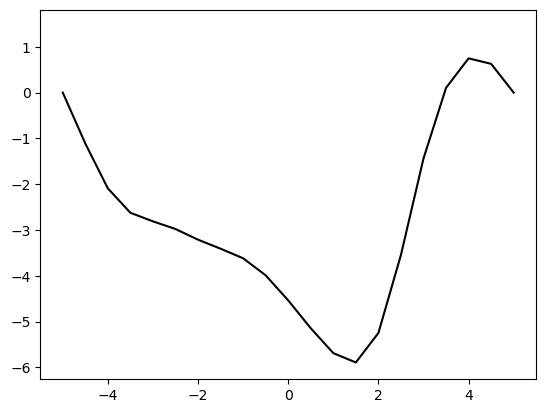

In [44]:
import matplotlib.animation as animation
def test_test():
    u = solve_wave(f_xt_samples[:, :, 0])  # Solution for f(x, t)
    # u = solve_wave(np.zeros((Nt,Nx)))
    fig = plt.figure()
    plts = []             # get ready to populate this list the Line artists to be plotted
    # plt.hold("off")
    for ti in range(0,Nt):
        p, = plt.plot(x, u[ti,:], 'k')   # this is how you'd plot a single line...
        plts.append( [p] )           # ... but save the line artist for the animation
    ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=3000)   # run the animation
    ani.save('wave2.mp4')    # optionally save it to a file

    plt.show()

# test_test()

In [34]:
#kernel model definition
def Kt(X, Y, col, K):
    l = K.get_params()['length_scale']
    coeff = - (1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T)
    return coeff * K(X, Y)

def Ktt(X, Y, col, K):
    l = K.get_params()['length_scale']
    coeff = (1/l**2) * ((1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T) ** 2 -1)
    return coeff * K(X,Y)


class KernelModel(BaseEstimator, RegressorMixin):
    def __init__(self, nugget=1e-7, length_scale=1, partial_derivative_order=0, partial_derivative_column=0):
        self.length_scale = length_scale
        self.nugget = nugget
        self.partial_derivative_order = partial_derivative_order
        self.partial_derivative_column = partial_derivative_column
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.K = RBF(length_scale=self.length_scale)
        UXX = self.K(self.X_, self.X_)
        UXX_nugget = (UXX + self.nugget ** 2 * np.eye(self.X_.shape[0]))
        self.UXX_inv_y = np.linalg.solve(UXX_nugget, self.y_)
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)

        if(self.partial_derivative_order == 0):
            UxX = self.K(X, self.X_)

        elif(self.partial_derivative_order == 1):
            UxX = Kt(X, self.X_, self.partial_derivative_column, self.K)

        elif(self.partial_derivative_order == 2):
            UxX = Ktt(X, self.X_, self.partial_derivative_column, self.K)
        return UxX @ self.UXX_inv_y

    def set_params(self, **params):
        if not params:
            return self

        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)

        return self

In [104]:
training_data = []
T,X = np.meshgrid(t, x, indexing='ij')
grid_points = np.c_[T.ravel(), X.ravel()]

for i in range(10):
    u = solve_wave(f_xt_samples[:, :, i])  # Solution for f(x, t)
    u = u.reshape(-1,1)
    u_std = np.std(u)
    noise = np.random.normal(0, 0.05 * u_std, Nt*Nx)
    u_perturbed = u + noise.reshape(-1,1)

    training_data.append(np.column_stack((grid_points, u_perturbed, u)))


In [89]:
#u_tt - c^2 u_xx = f(x,t)
#aim learn P(s) = f(x,t)
#s = ?   s= [X,u_tt,u_xx]
#  s^{1} ==  [s_{1}^{1} = [0,0,u_tt(0,0),u_xx(0,0)]  ...... s_{2500}^{1}]
# S = [s^{1} ......s^{10}] : 10 sorucing term
#
S_array = []
best_params = []
cv_results = []
l_range = np.arange(0.01, 1, 0.01)
eta = 5e-8
i = 0
for data in training_data:
    grid_points = data[:,0:2]
    u_sample = data[:, 3]

    cv = ShuffleSplit(n_splits=10, random_state=0)
    grid_search = GridSearchCV(estimator=KernelModel(eta, 1),
                               param_grid={'length_scale': l_range},
                               cv=cv,
                               scoring='neg_mean_squared_error')

    # Fit the GridSearchCV
    grid_search.fit(grid_points, u_sample)
    km = grid_search.best_estimator_
    s0 = grid_points
    s1 = km.set_params(partial_derivative_order=2,partial_derivative_column=0).predict(grid_points)
    s2 = km.set_params(partial_derivative_order=2,partial_derivative_column=1).predict(grid_points)
    Si = np.column_stack((s0, s1, s2))
    S_array.append(Si)
    best_params.append(grid_search.best_params_)
    cv_results.append(grid_search.cv_results_)
    print(i, grid_search.best_params_)
    i += 1

# Display the generated results
# print("Best Parameters:", best_params)
# print("Cross-Validation Results:", cv_results)
# print("S Array:", S_array)


0 {'length_scale': 0.17}
1 {'length_scale': 0.2}
2 {'length_scale': 0.21}
3 {'length_scale': 0.21}
4 {'length_scale': 0.16}
5 {'length_scale': 0.17}
6 {'length_scale': 0.17}
7 {'length_scale': 0.19}
8 {'length_scale': 0.19}
9 {'length_scale': 0.19}


In [47]:
S = np.vstack(S_array)

In [113]:
P_l_range = np.arange(0.0001, 0.1, 0.01)
P_eta = 1e-7

y_list = []
for i in range(10):
  k = f_xt_samples[:,:,i].reshape(-1,1)
  y_list.append(k)
y = np.vstack(y_list).reshape(-1)
X = S

X_test = S[0:Nt*Nx,:]
y_test = y[0:Nt*Nx]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('km', KernelModel(P_eta, 1))
])
# X_scaled = scaler

cv = ShuffleSplit(n_splits=10, random_state=0)
grid_search = GridSearchCV(pipeline,
                            param_grid={'km__length_scale': P_l_range},
                            cv=cv,
                            scoring='neg_mean_squared_error'
                            )

# Fit the GridSearchCV
grid_search.fit(X, y)
km = grid_search.best_estimator_
P_star = km.predict(X_test)

In [ ]:
def test_test():
    # u = solve_wave(np.zeros((Nt,Nx)))
    fig = plt.figure()
    plts = []             # get ready to populate this list the Line artists to be plotted
    # plt.hold("off")
    X_test = S[0:Nt*Nx,:]
    y_test = y[0:Nt*Nx]
    for ti in range(0,Nt):
        p, = plt.plot(x, u[ti,:], 'k')   # this is how you'd plot a single line...
        plts.append( [p] )           # ... but save the line artist for the animation
    ani = animation.ArtistAnimation(fig, plts, interval=50, repeat_delay=3000)   # run the animation
    ani.save('wave2.mp4')    # optionally save it to a file

    plt.show()

# test_test()

-2.364000358869039
{'km__length_scale': 0.0001}


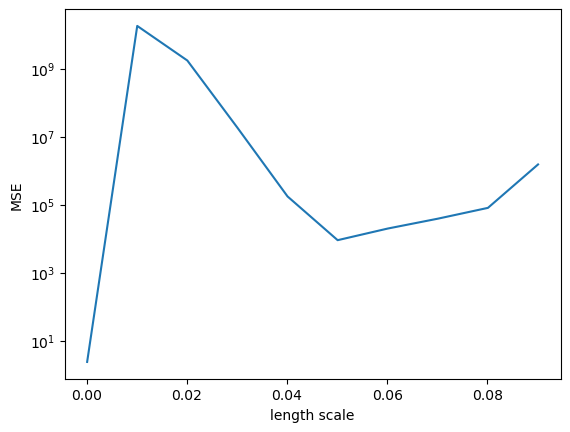

In [114]:
df = pd.DataFrame(grid_search.cv_results_)
plt.figure()
plt.semilogy(P_l_range, -df['mean_test_score'])
plt.xlabel('length scale')
plt.ylabel('MSE')
print(grid_search.best_score_)
print(grid_search.best_params_)

In [66]:
mean_squared_error(P_star, y_test)

1.387259390764054e-09

In [51]:
y_test

array([ 0.20003297, -0.2516297 , -0.42753529, -0.34157263, -0.26721051,
       -0.33351064, -0.22004249,  0.28801837,  0.90000089,  0.95462426,
        0.12071743, -0.9368707 , -1.39708714, -1.26333372, -0.83406627,
       -0.05540275,  0.84975784,  1.19040072,  0.90618845,  0.67265795,
        0.85616448,  0.15475163, -0.29141774, -0.47333876, -0.37924849,
       -0.28097357, -0.35093933, -0.27855737,  0.19298576,  0.77523841,
        0.76991524, -0.1341653 , -1.21361794, -1.64304846, -1.48491886,
       -1.05676892, -0.24897867,  0.7383553 ,  1.18284483,  0.99483546,
        0.84028725,  1.08244983,  0.10657508, -0.34446145, -0.5396057 ,
       -0.44419554, -0.32933528, -0.40695428, -0.37776047,  0.0533833 ,
        0.60673002,  0.55868219, -0.38391342, -1.46147329, -1.86383379,
       -1.70432865, -1.2949016 , -0.46234623,  0.60673765,  1.1546025 ,
        1.06318636,  0.98353452,  1.26713301,  0.06352883, -0.40516874,
       -0.62455024, -0.53884192, -0.41738628, -0.50535815, -0.51

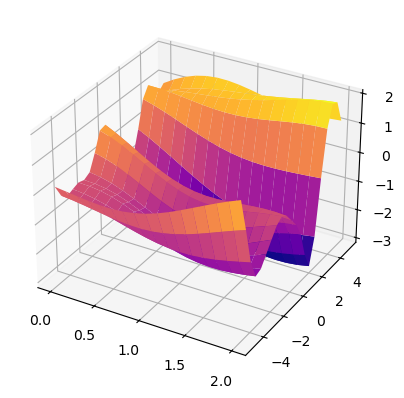

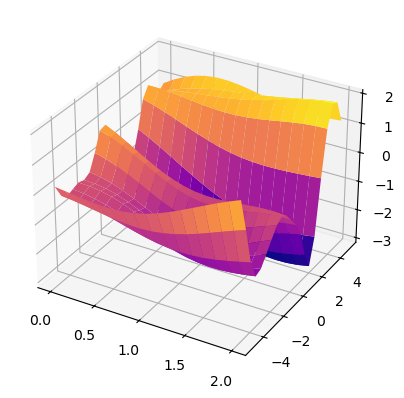

In [121]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

X1,X2 = np.meshgrid(t, x, indexing='ij')

plt.figure()
ax = plt.axes(projection='3d')
# Plot the solution
cmap = mpl.colormaps['plasma']
ax.plot_surface(X1, X2, f_xt_samples[:,:,0], cmap=cmap)

plt.figure()
ax = plt.axes(projection='3d')
# Plot the solution
cmap = mpl.colormaps['plasma']
P_star = km.predict(X_test)
ax.plot_surface(X1, X2, P_star.reshape((Nt,Nx)), cmap=cmap)

In [111]:
km = grid_search.best_estimator_
km

KernelModel(length_scale=0.19, nugget=5e-08, partial_derivative_column=1,
            partial_derivative_order=2)